# Dados e Aprendizagem Automática
### Part VIII

## **Multi Layer Percepreton using Titanic Dataset - I**

#### Imports, installations and settings

Install Pytorch: https://pytorch.org/get-started/locally/

In [131]:
import sklearn as skl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

%matplotlib inline

device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [132]:
print(torch.__version__)

2.5.1


#### FE and EDA on Titanic Dataset

Load the CSV - *Titanic*

In [133]:
df = pd.read_csv("titanic.csv")

Inspect data

In [134]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Impute by mean the *Nan* values of *Age*

In [136]:
def med_impute_nan(df):
    med_impute = df.copy()
    med_impute["Age"] = med_impute["Age"].fillna(med_impute["Age"].median())
    return med_impute

In [137]:
med_impute = med_impute_nan(df)

In [138]:
df = med_impute
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [139]:
embark = df['Embarked'].dropna()

In [140]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [141]:
df['Cabin'] = df['Cabin'].fillna(df['Cabin'].mode()[0])

In [142]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [143]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

In [144]:
df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

In [145]:
from sklearn.preprocessing import LabelEncoder

cols = ['Embarked']
le = LabelEncoder()

for col in cols:
    df[col] = le.fit_transform(df[col])
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,1,22.0,1,0,7.2500,2
1,2,1,1,0,38.0,1,0,71.2833,0
2,3,1,3,0,26.0,0,0,7.9250,2
3,4,1,1,0,35.0,1,0,53.1000,2
4,5,0,3,1,35.0,0,0,8.0500,2


Save dataset into a new file

In [146]:
t = pd.DataFrame(df)
filename = "titanic_ds.csv"
t.to_csv(filename, index=False, encoding='utf-8')

**Target: *Pclass***

In [147]:
df_X = t.drop('Pclass', axis=1)
df_X.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,1,22.0,1,0,7.2500,2
1,2,1,0,38.0,1,0,71.2833,0
2,3,1,0,26.0,0,0,7.9250,2
3,4,1,0,35.0,1,0,53.1000,2
4,5,0,1,35.0,0,0,8.0500,2


In [148]:
t_X = pd.DataFrame(df_X)
filename = "titanic_x.csv"
t_X.to_csv(filename, index=False, encoding='utf-8')

In [149]:
df_y = t['Pclass']
df_y.head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [150]:
t_y = pd.DataFrame(df_y)
filename = "titanic_y.csv"
t_y.to_csv(filename, index=False, encoding='utf-8')

#### Data Preparation

In [151]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor

class CSVDataset(Dataset):
    def __init__(self, path):
        df_X = pd.read_csv("titanic_x.csv", header=0)
        df_y = pd.read_csv("titanic_y.csv", header=0)
        self.X = df_X.values
        self.y = df_y.values[:, 0]-1
        self.X = self.X.astype('float32')
        self.y = torch.tensor(self.y, dtype=torch.long, device=device)
        print(self.X.shape)
        print(self.y.shape)
        print(self.X.ndim)
        print(self.y.ndim)
        print(self.X.dtype)
        print(self.y.dtype)

        
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    def get_splits(self, n_test):
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])
    
def prepare_data(df, n_test):
    dataset = CSVDataset(df)
    train, test = dataset.get_splits(n_test)
    train_dl = DataLoader(train, batch_size=len(train), shuffle=True)
    test_dl = DataLoader(test, batch_size=len(train), shuffle=True)
    return train_dl, test_dl

In [152]:
train_dl, test_dl = prepare_data(df, 0.33)

(891, 8)
torch.Size([891])
2
1
float32
torch.int64


#### Data Balance

In [153]:
from IPython.display import display

display()

In [154]:
display(df_y)

0      3
1      1
2      3
3      1
4      3
      ..
886    2
887    1
888    3
889    1
890    3
Name: Pclass, Length: 891, dtype: int64

In [155]:
def visualize_dataset(train_dl, test_dl):
    print(f"Train size:{len(train_dl.dataset)}") 
    print(f"Test size:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor train data batch - input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f"Shape tensor test data batch - input: {x.shape}, output: {y.shape}")

In [156]:
visualize_dataset(train_dl, test_dl)

Train size:597
Test size:294
Shape tensor train data batch - input: torch.Size([597, 8]), output: torch.Size([597])
Shape tensor test data batch - input: torch.Size([294, 8]), output: torch.Size([294])


In [157]:
def visualize_holdout_balance(train_dl, test_dl):
    _, y_train = next(iter(train_dl))                            
    _, y_test = next(iter(test_dl))
    
    sns.set_style('whitegrid')
    train_df = len(y_train) 
    test_df = len(y_test)
    Class_1_train = np.count_nonzero(y_train == 0)
    Class_2_train = np.count_nonzero(y_train == 1)
    Class_3_train = np.count_nonzero(y_train == 2)
    print("train data: ", train_df)
    print("Class 1: ", Class_1_train) 
    print("Class 2: ", Class_2_train)
    print("Class 3: ", Class_3_train)
    print("Values' mean (train): ", np.mean(y_train.numpy()))

    Class_1_test = np.count_nonzero(y_test == 0)
    Class_2_test = np.count_nonzero(y_test == 1)
    Class_3_test = np.count_nonzero(y_test == 2)
    print("test data: ", test_df)
    print("Class 1: ", Class_1_test) 
    print("Class 2: ", Class_2_test)
    print("Class 3: ", Class_3_test)
    print("Values' mean (test): ", np.mean(y_test.numpy()))

    graph = sns.barplot(x=['Class 1 train', 'Class 2 train', 'Class 3 train',
                           'Class 1 test', 'Class 2 test', 'Class 3 test'], 
                        y=[Class_1_train, Class_2_train, Class_3_train,
                           Class_1_test, Class_2_test, Class_3_test])
    
    graph.set_title('Data balance by class')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.savefig('data_balance_MLP.png')
    plt.show() 

    graph = sns.barplot(x=['Train data average','Test data average'], 
                        y=[np.mean(y_train.numpy()), np.mean(y_test.numpy())])
    graph.set_title('Data balance by mean')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

train data:  597
Class 1:  148
Class 2:  125
Class 3:  324
Values' mean (train):  1.2948073701842546
test data:  294
Class 1:  68
Class 2:  59
Class 3:  167
Values' mean (test):  1.336734693877551


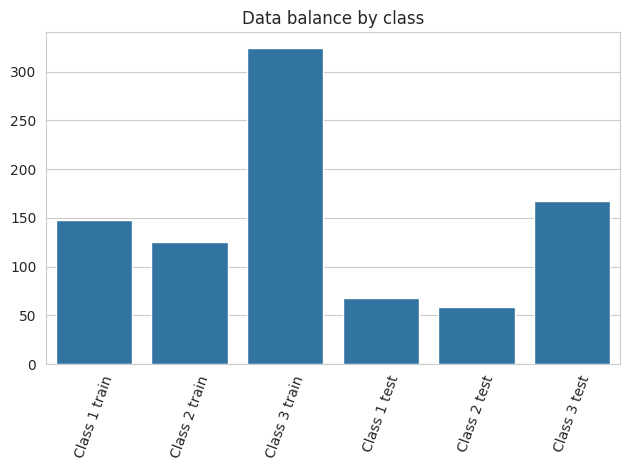

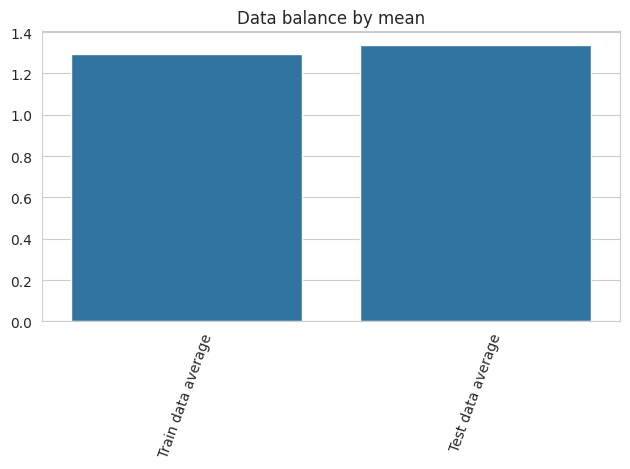

In [158]:
visualize_holdout_balance(train_dl,test_dl )

#### MLP Model 1

In [159]:
EPOCHS = 200
LEARNING_RATE = 0.001

In [160]:
from torch.nn import Module, Linear, ReLU, Softmax, Sigmoid
from torch.nn.init import xavier_uniform_, kaiming_uniform_

class MLP_1(Module):
    def __init__(self, n_inputs):
        super(MLP_1, self).__init__()
        self.hidden1 = Linear(n_inputs, 24 )
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.hidden2 = Linear(24,12 )
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        self.hidden3 = Linear(12,3 )
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)
 
    def forward(self, X):
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        X = self.hidden3(X)
        X = self.act3(X)
        return X

Define the neural network

In [161]:
model = MLP_1(8)

Visualize the network

In [162]:
from torchinfo import summary

print(summary(model, input_size=(len(train_dl.dataset), 8), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MLP_1                                    [597, 3]                  --
├─Linear: 1-1                            [597, 24]                 216
├─ReLU: 1-2                              [597, 24]                 --
├─Linear: 1-3                            [597, 12]                 300
├─ReLU: 1-4                              [597, 12]                 --
├─Linear: 1-5                            [597, 3]                  39
├─Softmax: 1-6                           [597, 3]                  --
Total params: 555
Trainable params: 555
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.33
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.00
Estimated Total Size (MB): 0.21


MLP_1(
  (hidden1): Linear(in_features=8, out_features=24, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=24, out_features=12, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=12, out_features=3, bias=True)
  (act3): Softmax(dim=1)
)

### Model 1 settings: Epochs=, LR=0., Softmax-3, CEL, SGD

#### Train the model

In [163]:
from livelossplot import PlotLosses
from torch.nn import CrossEntropyLoss, MSELoss
from torch.optim import SGD, Adam

def train_model(train_dl, val_dl, model):
    liveloss = PlotLosses()
    
    criterion = ()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    
    for epoch in range(EPOCHS):
        logs = {}
        model.train()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            
            loss.backgrand()
            optimizer.step()
            
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()

        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()   
        liveloss.update(logs)
        liveloss.send()

In [168]:
train_model(train_dl, test_dl , model)

TypeError: 'tuple' object is not callable

#### Evaluate the model

In [ ]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(test_dl):
        yprev = model(inputs)
        yprev = yprev.detach().numpy()
        actual = labels.numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)

In [ ]:
def display_confusion_matrix(cm):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm, annot=True, xticklabels=['Class 1', 'Class 2', 'Class 3'],
                yticklabels=['Class 1', 'Class 2', 'Class 3'], 
                annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

In [ ]:
predictions, actual_values = evaluate_model(test_dl, model)

In [ ]:
success = 0
failure = 0
for r,p in zip(actual_values, predictions):
    print(f'real:{r+1} prediction:{p+1}') 
    if r==p: success+=1  
    else: failure+=1

real:[3] prediction:[3]
real:[2] prediction:[3]
real:[2] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[1] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[1] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[2] prediction:[3]
real:[1] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[1] prediction:[3]
real:[1] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[1] prediction:[3]
real:[2] prediction:[3]
real:[3] prediction:[3]
real:[2] prediction:[3]
real:[2] predict

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(actual_values, predictions)
print(f'Accuracy: {acc:0.3f}\n')
print(f'success:{success} failure:{failure}')

Accuracy: 0.527

success:155 failure:139


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(actual_values, predictions ))
cm = confusion_matrix(actual_values, predictions )
print(cm)
display_confusion_matrix(cm)

#### Apply the model

Make a prediction using one case:

In [ ]:
def predict(row, model):
    row = Tensor([row])
    yprev = model(row)
    yprev = yprev.detach().numpy()
    return yprev

In [ ]:
row = [5, 0, 1, 34, 0, 1, 8, 1]
yprev = predict(row, model)
print('Predicted: %s (class=%d)' % (yprev, np.argmax(yprev)+1))

Predicted: [[0.01178731 0.00209614 0.9861166 ]] (class=3)
